<a href="https://colab.research.google.com/github/kinjaljoshi/actor_defender_setup/blob/main/actor_defender_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install langchain openai langchain_community

In [50]:
import os
from google.colab import userdata
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent
from langchain.prompts import BaseChatPromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
import json
import matplotlib.pyplot as plt

api_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = api_key
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")


In [19]:
# Payoff parameters
ALPHA = 6   # Reward for a successful exploit
COST = 2    # Cost to mount any attack
BETA = 2    # Additional penalty if a new rule is added
DELTA = 8   # Negative cost for defender if exploit succeeds
GAMMA = 3   # Benefit for adding new rule
RHO = 0     # Baseline payoff if exploit fails

# Initial rules, schema, and operations (from the prompt)
sample_schema = {"id": str, "name": str, "age": int, "status": str}
sample_operations = {
    "create": {"desc": "Create object with provided name, age, status, id"},
    "updateStatus": {"desc": "Update object with provided id to new status"},
    "updateAge": {"desc": "Update object with provided id to new age"}
}
initial_rules = [
    "age must be greater than 0",
    "status must be 'active' or 'inactive'",
    "id must be unique for all objects"
]


In [14]:
def compute_payoffs(exploit_success, defender_action):
    """
    Returns (actor_payoff, defender_payoff) for this round.
    """
    if exploit_success and defender_action == "MaintainRules":
        # Attack succeeds, no new rule
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        # Attack succeeds, new rule added
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        # Exploit fails
        return (-COST, RHO)

In [15]:
ACTOR_SYSTEM_PROMPT = """\
You are an attacking agent trying to find an operation (create, updateStatus, updateAge)
that violates or bypasses the current rules to maximize your payoff.
Return your chosen 'operation' and 'params' in JSON.
"""

DEFENDER_SYSTEM_PROMPT = """\
You are a defending agent. Given the actor's exploit:
1) Decide whether to MaintainRules or AddRule (to block it),
2) If you add a rule, provide the new rule text.

Return JSON:
{
  "action": "MaintainRules" or "AddRule",
  "new_rule": "..."
}
"""

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, current_rules, known_operations):
        messages = [
            SystemMessage(content=ACTOR_SYSTEM_PROMPT),
            HumanMessage(
                content=(
                    f"Current Rules:\n{current_rules}\n\n"
                    f"Available Operations:\n{known_operations}\n\n"
                    "Propose your exploit in JSON:"
                )
            )
        ]
        response = self.llm(messages)
        return response.content


class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json, current_rules):
        messages = [
            SystemMessage(content=DEFENDER_SYSTEM_PROMPT),
            HumanMessage(
                content=(
                    f"Actor's exploit:\n{exploit_json}\n\n"
                    f"Current Rules:\n{current_rules}\n\n"
                    "Decide action in JSON:"
                )
            )
        ]
        response = self.llm(messages)
        return response.content


In [16]:
def process_exploit(exploit_json, current_rules, objects_db):
    """
    Simple direct rule check:
      - parse exploit,
      - see if it violates any text-based constraints,
      - if no violation, apply it => success = True; else => False
    """

    def violates_rules(op, params, rules, db):
        # Very simplistic checks for demonstration:
        # 1) "age must be greater than 0"
        # 2) "status must be 'active' or 'inactive'"
        # 3) "id must be unique for all objects"
        # Real systems could parse with an LLM or do more advanced logic
        if "age must be greater than 0" in rules:
            if "age" in params and params["age"] <= 0:
                return True
        if "status must be 'active' or 'inactive'" in rules:
            if "status" in params and params["status"] not in ["active", "inactive"]:
                return True
        if "id must be unique for all objects" in rules and op == "create":
            new_id = params.get("id", "")
            if new_id in db:
                return True
        return False

    try:
        data = json.loads(exploit_json)
        operation = data.get("operation", "")
        params = data.get("params", {})

        # Check rules
        if violates_rules(operation, params, current_rules, objects_db):
            return False  # exploit fails

        # If no violation, apply operation
        if operation == "create":
            obj_id = params["id"]
            objects_db[obj_id] = {
                "name": params.get("name", "unknown"),
                "age": params.get("age", 0),
                "status": params.get("status", "inactive")
            }
        elif operation == "updateStatus":
            obj_id = params.get("id", "")
            if obj_id in objects_db:
                objects_db[obj_id]["status"] = params.get("status", "inactive")
            else:
                return False
        elif operation == "updateAge":
            obj_id = params.get("id", "")
            if obj_id in objects_db:
                objects_db[obj_id]["age"] = params.get("age", 0)
            else:
                return False
        else:
            # Unknown operation => fail
            return False

        return True
    except:
        return False


In [17]:
def simulate_game_and_plot(num_rounds=5):
    llm = ChatOpenAI(temperature=0)

    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)

    current_rules = initial_rules.copy()
    objects_db = {}

    # Track payoffs per round
    actor_payoffs = []
    defender_payoffs = []

    actor_cumulative = 0
    defender_cumulative = 0

    for round_index in range(1, num_rounds+1):
        print(f"\n=== Round {round_index} ===")

        # 1. Actor proposes exploit
        exploit_json = actor.propose_exploit(current_rules, sample_operations)
        print("Actor's exploit proposal:", exploit_json)

        # 2. Check exploit success
        success = process_exploit(exploit_json, current_rules, objects_db)

        # 3. If success, Defender decides next action
        defender_action = "MaintainRules"
        new_rule = ""
        if success:
            defender_resp = defender.respond_to_exploit(exploit_json, current_rules)
            print("Defender response:", defender_resp)
            try:
                data = json.loads(defender_resp)
                defender_action = data.get("action", "MaintainRules")
                new_rule = data.get("new_rule", "")
            except:
                pass

            if defender_action == "AddRule" and new_rule:
                current_rules.append(new_rule)

        # 4. Compute payoffs
        a_payoff, d_payoff = compute_payoffs(success, defender_action)
        actor_cumulative += a_payoff
        defender_cumulative += d_payoff

        actor_payoffs.append(actor_cumulative)
        defender_payoffs.append(defender_cumulative)

        print(f"Actor payoff (this round): {a_payoff}, cumulative: {actor_cumulative}")
        print(f"Defender payoff (this round): {d_payoff}, cumulative: {defender_cumulative}")
        print("Objects DB:", objects_db)
        print("Current Rules:", current_rules)

    # Plot the payoff lines
    rounds = list(range(1, num_rounds + 1))
    plt.figure(figsize=(8,5))
    plt.plot(rounds, actor_payoffs, label="Actor Cumulative Payoff", marker="o")
    plt.plot(rounds, defender_payoffs, label="Defender Cumulative Payoff", marker="s")

    plt.title("Actor vs. Defender Cumulative Payoffs Over Rounds")
    plt.xlabel("Round")
    plt.ylabel("Cumulative Payoff")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final payoff totals
    print("\n=== Final Results ===")
    print(f"Actor's total payoff: {actor_cumulative}")
    print(f"Defender's total payoff: {defender_cumulative}")
    print("Final Rules:")
    for rule in current_rules:
        print(f" - {rule}")

    # Simple heuristic for detecting equilibrium
    # (In practice, you'd do deeper analysis or run more rounds)
    if actor_cumulative <= 0:
        print("Possible Equilibrium: Actor can't profit; Defender effectively blocks.")
    else:
        print("Actor found some profit. Further rounds may be needed to confirm equilibrium.")



=== Round 1 ===


<ipython-input-15-273ac88ccdef>:34: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = self.llm(messages)


Actor's exploit proposal: {
    "operation": "create",
    "params": {
        "name": "John",
        "age": -5,
        "status": "active",
        "id": 123
    }
}
Actor payoff (this round): -2, cumulative: -2
Defender payoff (this round): 0, cumulative: 0
Objects DB: {}
Current Rules: ['age must be greater than 0', "status must be 'active' or 'inactive'", 'id must be unique for all objects']

=== Round 2 ===
Actor's exploit proposal: {
    "operation": "create",
    "params": {
        "name": "John",
        "age": -5,
        "status": "active",
        "id": 123
    }
}
Actor payoff (this round): -2, cumulative: -4
Defender payoff (this round): 0, cumulative: 0
Objects DB: {}
Current Rules: ['age must be greater than 0', "status must be 'active' or 'inactive'", 'id must be unique for all objects']

=== Round 3 ===
Actor's exploit proposal: {
    "operation": "create",
    "params": {
        "name": "John",
        "age": -5,
        "status": "active",
        "id": 123
    }


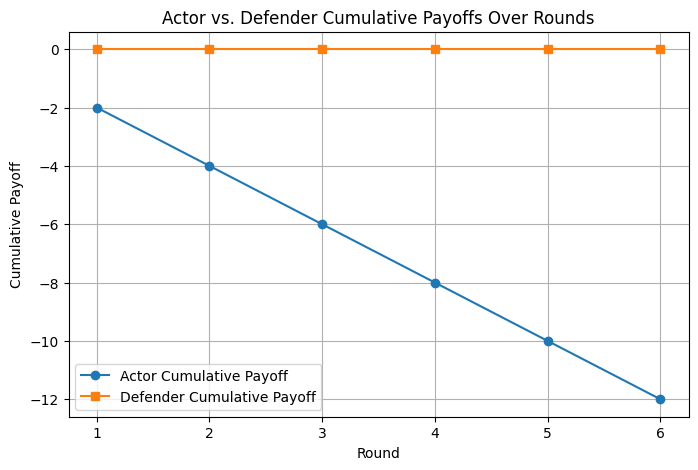


=== Final Results ===
Actor's total payoff: -12
Defender's total payoff: 0
Final Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
Possible Equilibrium: Actor can't profit; Defender effectively blocks.


In [20]:
simulate_game_and_plot(num_rounds=6)

New Rivision

In [21]:
import os
import json
from typing import List, Dict

# If you plan to use OpenAI, set your API key:
# os.environ["OPENAI_API_KEY"] = "YOUR-OPENAI-KEY"

# LangChain imports
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage

###############################################################################
# 1. GAME PARAMETERS
###############################################################################

# Basic payoff parameters for the repeated game:
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    """
    Returns (actor_payoff, defender_payoff) based on the simple game-theoretic model.
    """
    if exploit_success and defender_action == "MaintainRules":
        # Exploit succeeds, no new rule added
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        # Exploit succeeds, new rule added
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        # Exploit fails
        return (-COST, RHO)

###############################################################################
# 2. ACTOR AGENT
###############################################################################

class ActorAgent:
    """
    The Actor tries to find an exploit (operation + params) that breaks or bypasses
    the current rules. We rely on an LLM to propose that exploit in JSON form.
    """

    ACTOR_SYSTEM_PROMPT = """\
You are an attacking agent. You have:
1) A schema of the object (keys and types).
2) A set of possible operations (create, update, etc.) with descriptions.
3) A list of existing security or validation rules.

You want to propose an operation and parameters that could break these rules
or gain a payoff if it is not blocked.

Output ONLY valid JSON in the format:
{
  "operation": "...",
  "params": { ... }
}
where "params" must match the object schema keys in some way.
Try to find a combination that is likely to violate or bypass the current rules.
"""

    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(
        self,
        object_schema: Dict[str, str],
        object_operations: Dict[str, Dict],
        current_rules: List[str]
    ) -> str:
        """
        Use an LLM to propose a malicious operation (exploit).
        Return a JSON string with fields: { "operation": ..., "params": {...} }.
        """
        # Convert data to text
        schema_text = json.dumps(object_schema, indent=2)
        ops_text = json.dumps(object_operations, indent=2)
        rules_text = "\n".join(f"- {r}" for r in current_rules)

        messages = [
            SystemMessage(content=self.ACTOR_SYSTEM_PROMPT),
            HumanMessage(content=(
                f"Object Schema:\n{schema_text}\n\n"
                f"Possible Operations:\n{ops_text}\n\n"
                f"Current Rules:\n{rules_text}\n\n"
                "Propose one exploit in JSON format only."
            ))
        ]
        response = self.llm(messages)
        return response.content.strip()

###############################################################################
# 3. LLM-BASED RULE CHECK
###############################################################################

CHECK_RULE_SYSTEM_PROMPT = """\
You are a rule-checking assistant. You have:
1) An object schema describing valid fields/types.
2) A list of security rules in natural language.
3) A proposed operation with parameters.

You must determine if this operation violates ANY of the rules.
If it violates at least one rule, respond "violation".
If it does not violate any rule, respond "no violation".
Respond with exactly one word: "violation" or "no violation".
"""

def check_rule_violation_with_llm(
    exploit_json: str,
    object_schema: Dict[str, str],
    current_rules: List[str],
    llm
) -> bool:
    """
    Return True if the exploit violates any rule (meaning exploit FAILS),
    or False if it doesn't violate (meaning exploit SUCCEEDS).
    """
    # Combine into a single prompt
    rules_text = "\n".join(f"- {r}" for r in current_rules)
    schema_text = json.dumps(object_schema, indent=2)

    content_str = (
        f"Object Schema:\n{schema_text}\n\n"
        f"Current Rules:\n{rules_text}\n\n"
        f"Proposed Exploit:\n{exploit_json}\n\n"
        "Does this exploit break any of the rules? "
        "Answer strictly 'violation' or 'no violation'."
    )

    messages = [
        SystemMessage(content=CHECK_RULE_SYSTEM_PROMPT),
        HumanMessage(content=content_str)
    ]
    response = llm(messages)
    answer = response.content.strip().lower()

    # If LLM returns "violation", that means the exploit fails
    # If LLM returns "no violation", exploit succeeds
    if "violation" in answer:
        return True  # rule violation => exploit fails
    return False     # no violation => exploit succeeds

###############################################################################
# 4. DEFENDER AGENT
###############################################################################

DEFENDER_SYSTEM_PROMPT = """\
You are a defender. If the exploit is successful, you must create a new rule
so that the same operation and parameters cannot be used again. You can reference
the exploit's operation/params to form a rule that prevents exactly that scenario.

Output JSON:
{
  "action": "AddRule" or "MaintainRules",
  "new_rule": "..."
}
"""

class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(
        self,
        exploit_json: str,
        exploit_success: bool,
        current_rules: List[str]
    ) -> str:
        """
        If exploit_success == True, we must generate a new rule
        preventing the same operation & params from reoccurring.
        Otherwise, we maintain rules.

        Return a JSON like:
        {
          "action": "AddRule",
          "new_rule": "When performing create with negative age, reject the request."
        }
        or
        {
          "action": "MaintainRules",
          "new_rule": ""
        }
        """
        if not exploit_success:
            # If the exploit failed, there's no new vulnerability discovered.
            # So do nothing new.
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        # If exploit was successful, ask LLM to generate a new rule
        # that blocks exactly that scenario in future attempts.
        # We'll feed the old rules to the LLM as well, so it doesn't repeat them.
        rules_text = "\n".join(f"- {r}" for r in current_rules)

        messages = [
            SystemMessage(content=DEFENDER_SYSTEM_PROMPT),
            HumanMessage(
                content=(
                    f"Current Rules:\n{rules_text}\n\n"
                    f"Successful Exploit:\n{exploit_json}\n\n"
                    "Generate a new rule to block this exploit in the future.\n"
                    "Return JSON only."
                )
            )
        ]
        response = self.llm(messages)
        return response.content.strip()

###############################################################################
# 5. MAIN SIMULATION LOGIC
###############################################################################

def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[str],
    num_rounds: int = 5
):
    """
    Simulate the Actor-Defender game for 'num_rounds' rounds.

    - Actor proposes exploit using LLM.
    - We check if it violates rules using LLM.
    - If no violation => exploit success => Defender adds new rule.
    - Payoffs are computed each round and printed.
    """
    # Instantiate a single LLM (chat model) for demonstration
    llm = ChatOpenAI(temperature=0)

    # Create our two agents
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)

    # Track rules, payoffs
    current_rules = initial_rules.copy()
    actor_cumulative_payoff = 0
    defender_cumulative_payoff = 0

    for round_idx in range(1, num_rounds + 1):
        print(f"\n=== Round {round_idx} ===")

        # 1) Actor proposes exploit
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules)
        print("Actor's exploit proposal:", exploit_json)

        # 2) Check if exploit violates any rule => fails if violation found
        violation_found = check_rule_violation_with_llm(
            exploit_json, object_schema, current_rules, llm
        )
        exploit_success = not violation_found

        # 3) Defender's response
        defender_response_raw = defender.respond_to_exploit(
            exploit_json, exploit_success, current_rules
        )
        print("Defender's response:", defender_response_raw)

        try:
            defender_data = json.loads(defender_response_raw)
            defender_action = defender_data.get("action", "MaintainRules")
            new_rule = defender_data.get("new_rule", "")
        except:
            defender_action = "MaintainRules"
            new_rule = ""

        # If there's a new rule, add it to current rules
        if defender_action == "AddRule" and new_rule.strip():
            current_rules.append(new_rule)
            print(f"** Defender added new rule: {new_rule}")

        # 4) Compute payoffs
        actor_payoff, defender_payoff = compute_payoffs(exploit_success, defender_action)
        actor_cumulative_payoff += actor_payoff
        defender_cumulative_payoff += defender_payoff

        # Print round summary
        print(f"Exploit Success? {exploit_success}")
        print(f"Actor payoff this round: {actor_payoff}, total: {actor_cumulative_payoff}")
        print(f"Defender payoff this round: {defender_payoff}, total: {defender_cumulative_payoff}")
        print("Current Rules:")
        for r in current_rules:
            print(" -", r)

    print("\n=== Simulation Complete ===")
    print(f"Actor's final payoff: {actor_cumulative_payoff}")
    print(f"Defender's final payoff: {defender_cumulative_payoff}")
    print("Final Rules:")
    for r in current_rules:
        print(" -", r)

###############################################################################
# 6. EXAMPLE USAGE
###############################################################################

if __name__ == "__main__":
    # Sample input from the user or from the prompt:
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }
    sample_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]

    # Run the simulation
    simulate_game(
        object_schema=sample_schema,
        object_operations=sample_operations,
        initial_rules=sample_rules,
        num_rounds=5
    )



=== Round 1 ===
Actor's exploit proposal: {
  "operation": "create",
  "params": {
    "id": "existing_id",
    "name": "John",
    "age": -5,
    "status": "active"
  }
}
Defender's response: {"action": "MaintainRules", "new_rule": ""}
Exploit Success? False
Actor payoff this round: -2, total: -2
Defender payoff this round: 0, total: 0
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects

=== Round 2 ===
Actor's exploit proposal: {
  "operation": "create",
  "params": {
    "id": "existing_id",
    "name": "John",
    "age": -5,
    "status": "active"
  }
}
Defender's response: {"action": "MaintainRules", "new_rule": ""}
Exploit Success? False
Actor payoff this round: -2, total: -4
Defender payoff this round: 0, total: 0
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects

=== Round 3 ===
Actor's exploit proposal: {
  "operation": "create",
  "p

10:22

In [4]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import os
from google.colab import userdata
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent
from langchain.prompts import BaseChatPromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
import json
import matplotlib.pyplot as plt

api_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = api_key
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")



# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str]) -> Dict:
        messages = [
            SystemMessage(content="Propose an exploit that violates existing rules. Output strictly in JSON format."),
            HumanMessage(content=f"""
                Schema: {json.dumps(object_schema)}
                Operations: {json.dumps(object_operations)}
                Rules: {json.dumps(current_rules)}
                Output format (JSON only):
                {{
                  "operation": "<operation_name>",
                  "params": {{
                    "key1": "value1",
                    "key2": "value2"
                  }}
                }}
                Ensure that the response does NOT include extra nesting like "exploit": {{...}}.
            """)
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for exploit proposal.")
            return {"operation": "none", "params": {}}

        try:
            exploit = json.loads(response_text)
            if "exploit" in exploit:  # Fix incorrectly nested responses
                exploit = exploit["exploit"]

            if "operation" not in exploit or "params" not in exploit:
                raise ValueError("Missing required keys in exploit JSON.")

            return exploit
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Error decoding LLM response: {response_text}\n{str(e)}")
            return {"operation": "none", "params": {}}



class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success: bool, current_rules: List[str]) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nExploit: {exploit_json}")
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        return response_text


def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[str],
    num_rounds: int
):
    llm = ChatOpenAI(temperature=0)
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()

    for _ in range(num_rounds):
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules)
        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = not any(str(param_value) in rule for param_value in exploit_json["params"].values() for rule in current_rules)

        defender_response_raw = defender.respond_to_exploit(
            json.dumps(exploit_json), exploit_success, current_rules
        )
        defender_data = json.loads(defender_response_raw)
        defender_action = defender_data.get("action", "MaintainRules")
        new_rule = defender_data.get("new_rule", "")

        if defender_action == "AddRule" and new_rule:
            current_rules.append(new_rule)
            print(f"Defender added new rule: {new_rule}")

        print(f"Exploit Success? {exploit_success}")
        print("Current Rules:")
        for r in current_rules:
            print(" -", r)

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }
    sample_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]

    simulate_game(sample_schema, sample_operations, sample_rules, num_rounds=5)


Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
Exploit Success? False
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
Exploit Success? False
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
Exploit Success? False
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
Exploit Success? False
Current Rules:
 - age must be greater than 0
 - status must

12:41 -- New Version

In [14]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str]) -> Dict:
        messages = [
            SystemMessage(content="Propose an exploit that violates existing rules. Output strictly in JSON format."),
            HumanMessage(content=f"""
                Schema: {json.dumps(object_schema)}
                Operations: {json.dumps(object_operations)}
                Rules: {json.dumps(current_rules)}
                Output format (JSON only):
                {{
                  "operation": "<operation_name>",
                  "params": {{
                    "key1": "value1",
                    "key2": "value2"
                  }}
                }}
                Ensure that the response does NOT include extra nesting like "exploit": {{...}}.
            """)
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for exploit proposal.")
            return {"operation": "none", "params": {}}

        try:
            exploit = json.loads(response_text)
            if "exploit" in exploit:  # Fix incorrectly nested responses
                exploit = exploit["exploit"]

            if "operation" not in exploit or "params" not in exploit:
                raise ValueError("Missing required keys in exploit JSON.")

            return exploit
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Error decoding LLM response: {response_text}\n{str(e)}")
            return {"operation": "none", "params": {}}

class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success, current_rules: List[str]) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nExploit: {exploit_json}")
        ]
        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
            return response_text
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

def check_exploit_success_with_llm(exploit_json: Dict, current_rules: List[str], llm) -> bool:
    messages = [
        SystemMessage(content="Determine if the operation will violate any existing object rules. Output 'violation' or 'no violation'."),
        HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nExploit: {json.dumps(exploit_json)}")
    ]
    response = llm(messages)
    response_text = response.content.strip().lower()
    print(f"LLM Response: {response_text}")
    return response_text != " no violation"

def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[str],
    num_rounds: int
):
    llm = ChatOpenAI(temperature=0)
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()

    for _ in range(num_rounds):
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules)
        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = check_exploit_success_with_llm(exploit_json, current_rules, llm)

        defender_response_raw = defender.respond_to_exploit(
            json.dumps(exploit_json), exploit_success, current_rules
        )
        print(f"Defender's response: {defender_response_raw}")
        defender_data = json.loads(defender_response_raw)
        print(f"Defender's data: {defender_data}")
        defender_action = defender_data.get("action", "MaintainRules")
        new_rule = defender_data.get("rule", "")
        print(f"Defender's action: {defender_action}")
        print(f"Defender's new rule: {new_rule}")

        if defender_action == "AddRule" and new_rule:
            current_rules.append(new_rule)
            print(f"Defender added new rule: {new_rule}")

        print(f"Exploit Success? {exploit_success}")
        print("Current Rules:")
        for r in current_rules:
            print(" -", r)

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }
    sample_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]

    simulate_game(sample_schema, sample_operations, sample_rules, num_rounds=5)


Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
LLM Response: violation
Defender's response: {
  "rule": "age must be a positive integer"
}
Defender's data: {'rule': 'age must be a positive integer'}
Defender's action: MaintainRules
Defender's new rule: age must be a positive integer
Exploit Success? True
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
LLM Response: violation
Defender's response: {
  "rule": "age must be a positive integer"
}
Defender's data: {'rule': 'age must be a positive integer'}
Defender's action: MaintainRules
Defender's new rule: age must be a positive integer
Exploit Success? True
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all obje

1:11 -- New Version

In [21]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str]) -> Dict:
        messages = [
            SystemMessage(content="Propose an exploit that violates existing rules. Output strictly in JSON format."),
            HumanMessage(content=f"""
                Schema: {json.dumps(object_schema)}
                Operations: {json.dumps(object_operations)}
                Rules: {json.dumps(current_rules)}
                Output format (JSON only):
                {{
                  "operation": "<operation_name>",
                  "params": {{
                    "key1": "value1",
                    "key2": "value2"
                  }}
                }}
                Ensure that the response does NOT include extra nesting like "exploit": {{...}}.
            """)
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for exploit proposal.")
            return {"operation": "none", "params": {}}

        try:
            exploit = json.loads(response_text)
            if "exploit" in exploit:  # Fix incorrectly nested responses
                exploit = exploit["exploit"]

            if "operation" not in exploit or "params" not in exploit:
                raise ValueError("Missing required keys in exploit JSON.")

            return exploit
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Error decoding LLM response: {response_text}\n{str(e)}")
            return {"operation": "none", "params": {}}

class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success: bool, current_rules: List[str]) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nExploit: {exploit_json}")
        ]
        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
            return json.dumps({"action": "AddRule", "new_rule": defender_response.get("rule", "")})
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

def check_exploit_success_with_llm(exploit_json: Dict, current_rules: List[str], llm) -> bool:
    messages = [
        SystemMessage(content="Determine if the exploit violates any existing rules. Output 'violation' or 'no violation'."),
        HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nExploit: {json.dumps(exploit_json)}")
    ]
    response = llm(messages)
    response_text = response.content.strip().lower()
    print(f"LLM exploit check Response: {response_text}")
    return response_text != "no violation"

def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[Dict],
    num_rounds: int
):
    llm = ChatOpenAI(temperature=0)
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()

    for _ in range(num_rounds):
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules)
        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = check_exploit_success_with_llm(exploit_json, current_rules, llm)

        defender_response_raw = defender.respond_to_exploit(
            json.dumps(exploit_json), exploit_success, current_rules
        )
        defender_data = json.loads(defender_response_raw)
        new_rule = defender_data.get("new_rule", "")

        if new_rule:
            current_rules.append({
                "validations": {
                    "operation": exploit_json["operation"],
                    "properties": {
                        list(exploit_json["params"].keys())[0]: {"rule": new_rule}
                    }
                }
            })
            print(f"Defender added new rule: {new_rule}")

        print(f"Exploit Success? {exploit_success}")
        print("Current Rules:")
        for r in current_rules:
            print(" -", r)

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }
    sample_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]

    simulate_game(sample_schema, sample_operations, sample_rules, num_rounds=5)


Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
LLM exploit check Response: violation
Defender added new rule: age must be greater than or equal to 0
Exploit Success? True
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
 - {'validations': {'operation': 'create', 'properties': {'id': {'rule': 'age must be greater than or equal to 0'}}}}
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age': -1, 'status': 'active'}}
LLM exploit check Response: violation
Exploit Success? True
Current Rules:
 - age must be greater than 0
 - status must be 'active' or 'inactive'
 - id must be unique for all objects
 - {'validations': {'operation': 'create', 'properties': {'id': {'rule': 'age must be greater than or equal to 0'}}}}
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John', 'age':

1:28 - New Version

In [48]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str], defend_rules: List[str]) -> Dict:
        print(f"current Operations {json.dumps(object_operations)}")
        print(f"defend Rules {json.dumps(defend_rules)}")
        messages = [
            SystemMessage(content="Propose an exploit that violates Master rules. Output strictly in JSON format."),
            HumanMessage(content=f"""
                Schema: {json.dumps(object_schema)}
                Operations: {json.dumps(object_operations)}
                Master Rules: {json.dumps(current_rules)}
                Honor Defence Validations for Master Rules when selecting operations: {json.dumps(defend_rules)}
                Output format (JSON only):
                {{
                  "operation": "<operation_name>",
                  "params": {{
                    "key1": "value1",
                    "key2": "value2"
                  }}
                }}
                Ensure that the response does NOT include extra nesting like "exploit": {{...}}.
            """)
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for exploit proposal.")
            return {"operation": "none", "params": {}}

        try:
            exploit = json.loads(response_text)
            if "exploit" in exploit:  # Fix incorrectly nested responses
                exploit = exploit["exploit"]

            if "operation" not in exploit or "params" not in exploit:
                raise ValueError("Missing required keys in exploit JSON.")

            return exploit
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Error decoding LLM response: {response_text}\n{str(e)}")
            return {"operation": "none", "params": {}}

class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success: bool) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Exploit: {exploit_json}")
        ]
        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
            return json.dumps({"action": "AddRule", "new_rule": defender_response.get("rule", "")})
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

# def check_exploit_success_with_llm(exploit_json: Dict, object_operations: Dict[str, Dict], llm) -> bool:
#     messages = [
#         SystemMessage(content="Determine if the exploit violates any existing rules. Output 'violation' or 'no violation'."),
#         HumanMessage(content=f"Operations: {json.dumps(object_operations)}\nExploit: {json.dumps(exploit_json)}")
#     ]
#     response = llm(messages)
#     response_text = response.content.strip().lower()
#     print(f"LLM exploit check Response: {response_text}")
#     return response_text != "no violation"

def check_exploit_success_with_llm(exploit_json: Dict, current_rules: List[str],defense_rules: List[str], llm) -> bool:
    messages = [
        SystemMessage(content="Determine if the exploit violates any existing rules. Output 'violation' or 'no violation'."),
        HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nDefense Rules: {json.dumps(defense_rules)}\nExploit: {json.dumps(exploit_json)}")
    ]
    response = llm(messages)
    response_text = response.content.strip().lower()
    print(f"LLM exploit check Response: {response_text}")
    return response_text != "no violation"


def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[Dict],
    num_rounds: int
):
    llm = ChatOpenAI(temperature=0)
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()
    defender_rules = []
    for _ in range(num_rounds):
        print(f"current Operations {json.dumps(object_operations)}")
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules,defender_rules)
        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = check_exploit_success_with_llm(exploit_json, current_rules,defender_rules, llm)

        defender_response_raw = defender.respond_to_exploit(
            json.dumps(exploit_json), exploit_success
        )
        defender_data = json.loads(defender_response_raw)
        new_rule = defender_data.get("new_rule", "")

        if new_rule:
            operation = exploit_json["operation"]
            if "validation" not in object_operations[operation]:
                object_operations[operation]["validation"] = []
            object_operations[operation]["validation"].append(new_rule)
            print(f"Defender added new rule: {new_rule}")
            defender_rules.append(new_rule)
            #defender_rules[operation] = new_rule

        print(f"Exploit Success? {exploit_success}")
        print("Current Operations:")
        for op, details in object_operations.items():
            print(f" - {op}: {details}")

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }

    master_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]
    simulate_game(sample_schema, sample_operations,master_rules, num_rounds=5)

current Operations {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
current Operations {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
defend Rules []
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John Doe', 'age': -5, 'status': 'active'}}
LLM exploit check Response: violation
Defender added new rule: Age must be a positive number
Exploit Success? True
Current Operations:
 - create: {'desc': 'create object with provided id, name, age, status', 'validation': ['Age must be a positive number']}
 - updateStatus: {'desc': 'update object with provided id to a new status'}
 - updateAge: {'desc': 'update object with provid

4:02 - new version

In [57]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

# class ActorAgent:
#     def __init__(self, llm):
#         self.llm = llm

#     def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str], defender_rules: Dict[str, List[str]]) -> Dict:
#         print(f"Current Operations: {json.dumps(object_operations)}")
#         print(f"Defender Rules: {json.dumps(defender_rules)}")
#         messages = [
#             SystemMessage(content="Propose an exploit that violates Master rules but does NOT violate Defender rules. Output strictly in JSON format."),
#             HumanMessage(content=f"""
#                 Schema: {json.dumps(object_schema)}
#                 Operations: {json.dumps(object_operations)}
#                 Master Rules: {json.dumps(current_rules)}
#                 Defender Rules : {json.dumps(defender_rules)}
#                 You must:
#                 - Find a way to violate Master Rules.
#                 - Ensure that the exploit does not contradict Defender Rules.
#                 - If no valid exploit exists, return: {{"operation": "none", "params": {"none"}}}

#                 Output format (JSON only):
#                 {{
#                   "operation": "<operation_name>",
#                   "params": {{
#                     "key1": "value1",
#                     "key2": "value2"
#                   }}
#                 }}
#                 Ensure that the response does NOT include extra nesting like "exploit": {{...}}.
#             """)
#         ]
#         # messages = [
#         #     SystemMessage(content="Propose an exploit that violates Master Rules but does NOT violate Defender Rules. Output strictly in JSON format."),
#         #     HumanMessage(content=f"""
#         #         Schema: {json.dumps(object_schema)}
#         #         Operations: {json.dumps(object_operations)}
#         #         Master Rules: {json.dumps(current_rules)}
#         #         Defender Rules (MUST NOT VIOLATE): {json.dumps(defender_rules)}

#         #         You must:
#         #         - Find a way to violate Master Rules.
#         #         - Ensure that the exploit does not contradict Defender Rules.
#         #         - If no valid exploit exists, return: {{"operation": "none", "params": {}}}

#         #         Output format (JSON only):
#         #         {{
#         #           "operation": "<operation_name>",
#         #           "params": {{
#         #             "key1": "value1",
#         #             "key2": "value2"
#         #           }}
#         #         }}
#         #     """)
#         # ]

#         response = self.llm(messages)
#         response_text = response.content.strip()

#         if not response_text:
#             print("Error: LLM returned an empty response for exploit proposal.")
#             return {"operation": "none", "params": {}}

#         try:
#             exploit = json.loads(response_text)
#             if "exploit" in exploit:
#                 exploit = exploit["exploit"]

#             if "operation" not in exploit or "params" not in exploit:
#                 raise ValueError("Missing required keys in exploit JSON.")

#             return exploit
#         except (json.JSONDecodeError, ValueError) as e:
#             print(f"Error decoding LLM response: {response_text}\n{str(e)}")
#             return {"operation": "none", "params": {}}

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str], defender_rules: Dict[str, List[str]]) -> Dict:
        print(f"Current Operations: {json.dumps(object_operations)}")
        print(f"Defender Rules: {json.dumps(defender_rules)}")

        # Construct a filter that prevents known rule violations
        filtered_operations = {
            op: details for op, details in object_operations.items()
            if op not in defender_rules or not defender_rules[op]  # Exclude operations that are fully blocked
        }

        if not filtered_operations:
            print("No valid operations remaining after filtering defender rules.")
            return {"operation": "none", "params": {}}

        messages = [
            SystemMessage(content="Propose an exploit that violates Master Rules but does NOT violate Defender Rules. Output strictly in JSON format."),
            HumanMessage(content=(
                f"Schema: {json.dumps(object_schema)}\n"
                f"Available Operations: {json.dumps(filtered_operations)}\n"
                f"Master Rules: {json.dumps(current_rules)}\n"
                f"Defender Rules (MUST NOT VIOLATE): {json.dumps(defender_rules)}\n\n"
                "You must:\n"
                "- Find a way to violate Master Rules.\n"
                "- Ensure that the exploit does not contradict Defender Rules.\n"
                "- If no valid exploit exists, return: {\"operation\": \"none\", \"params\": {}}\n\n"
                "Output format (JSON only):\n"
                "{\n"
                '  "operation": "<operation_name>",\n'
                '  "params": {\n'
                '    "key1": "value1",\n'
                '    "key2": "value2"\n'
                "  }\n"
                "}\n"
            ))
        ]

        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for exploit proposal.")
            return {"operation": "none", "params": {}}

        try:
            exploit = json.loads(response_text)
            if "exploit" in exploit:  # Fix incorrectly nested responses
                exploit = exploit["exploit"]

            if "operation" not in exploit or "params" not in exploit:
                raise ValueError("Missing required keys in exploit JSON.")

            # If exploit is already blocked, discard and request a new one
            if exploit["operation"] in defender_rules:
                for rule in defender_rules[exploit["operation"]]:
                    if any(str(value) in rule for value in exploit["params"].values()):
                        print(f"Exploit '{exploit}' violates an existing rule: {rule}. Rejecting.")
                        return {"operation": "none", "params": {}}

            return exploit
        except (json.JSONDecodeError, ValueError) as e:
            print(f"Error decoding LLM response: {response_text}\n{str(e)}")
            return {"operation": "none", "params": {}}


class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success: bool) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Exploit: {exploit_json}")
        ]
        response = self.llm(messages)
        response_text = response.content.strip()

        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
            return json.dumps({"action": "AddRule", "new_rule": defender_response.get("rule", "")})
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

def check_exploit_success_with_llm(exploit_json: Dict, current_rules: List[str], defender_rules: Dict[str, List[str]], llm) -> bool:
    messages = [
        SystemMessage(content="Determine if the exploit violates any existing rules. Output 'violation' or 'no violation'."),
        HumanMessage(content=f"Current Rules: {json.dumps(current_rules)}\nDefender Rules: {json.dumps(defender_rules)}\nExploit: {json.dumps(exploit_json)}")
    ]
    response = llm(messages)
    response_text = response.content.strip().lower()
    print(f"LLM exploit check Response: {response_text}")
    return response_text != "no violation"

def simulate_game(
    object_schema: Dict[str, str],
    object_operations: Dict[str, Dict],
    initial_rules: List[str],
    num_rounds: int
):
    llm = ChatOpenAI(temperature=0)
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()
    defender_rules = {}

    for _ in range(num_rounds):
        print(f"Current Operations: {json.dumps(object_operations)}")
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules, defender_rules)
        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = check_exploit_success_with_llm(exploit_json, current_rules, defender_rules, llm)

        defender_response_raw = defender.respond_to_exploit(
            json.dumps(exploit_json), exploit_success
        )
        defender_data = json.loads(defender_response_raw)
        new_rule = defender_data.get("new_rule", "")

        if new_rule:
            operation = exploit_json["operation"]
            if operation not in defender_rules:
                defender_rules[operation] = []
            defender_rules[operation].append(new_rule)
            print(f"Defender added new rule: {new_rule}")

        print(f"Exploit Success? {exploit_success}")
        print("Current Operations:")
        for op, details in object_operations.items():
            print(f" - {op}: {details}")

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }

    master_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]
    simulate_game(sample_schema, sample_operations, master_rules, num_rounds=5)


Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Defender Rules: {}
Actor's exploit proposal: {'operation': 'create', 'params': {'id': '1', 'name': 'John Doe', 'age': -5, 'status': 'active'}}
LLM exploit check Response: violation
Defender added new rule: Age must be a positive number
Exploit Success? True
Current Operations:
 - create: {'desc': 'create object with provided id, name, age, status'}
 - updateStatus: {'desc': 'update object with provided id to a new status'}
 - updateAge: {'desc': 'update object with provided id to a new age'}
Current Operations: {"c

KeyboardInterrupt: 

4:20 - New version

In [78]:
import os
import json
from typing import List, Dict
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage





# Game parameters
ALPHA = 6   # Reward for Actor on successful exploit
COST = 2    # Cost to mount an exploit
BETA = 2    # Extra penalty to Actor if a new rule is added
DELTA = 8   # Cost to Defender if exploit succeeds
GAMMA = 3   # Benefit to Defender for adding a rule
RHO   = 0   # Defender's payoff if exploit fails (baseline 0)

def compute_payoffs(exploit_success: bool, defender_action: str):
    if exploit_success and defender_action == "MaintainRules":
        return (ALPHA - COST, -DELTA)
    elif exploit_success and defender_action == "AddRule":
        return (ALPHA - COST - BETA, -DELTA + GAMMA)
    else:
        return (-COST, RHO)

class ActorAgent:
    def __init__(self, llm):
        self.llm = llm
        self.tried_exploits = set()  # Store previous exploits to prevent repetition
        self.max_retries = 5  # Limit the number of attempts per operation

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str], defender_rules: Dict[str, List[str]]) -> Dict:
        print(f"Current Operations: {json.dumps(object_operations)}")
        print(f"Defender Rules: {json.dumps(defender_rules)}")

        for operation, details in object_operations.items():
            print(f"Trying Operation: {operation}")

            retries = 0  # Track the number of attempts for this operation
            while retries < self.max_retries:  # Stop if retries exceed limit
                messages = [
                    SystemMessage(content=f"Find an exploit for the '{operation}' operation. Modify parameters one by one or in combination to find new defects. Try a new exploit if the previous one was unsuccessful."),
                    HumanMessage(content=(
                        f"Schema: {json.dumps(object_schema)}\n"
                        f"Operation: {json.dumps({operation: details})}\n"
                        f"Master Rules: {json.dumps(current_rules)}\n"
                        f"Defender Rules (MUST NOT VIOLATE): {json.dumps(defender_rules)}\n"
                        f"Previously Tried Exploits (DO NOT REPEAT): {json.dumps(list(self.tried_exploits))}\n\n"
                        "## You must:\n"
                        "- Modify **one** or more parameters to find a new exploit.\n"
                        "- Do **not** repeat previous exploits.\n"
                        "- Keep trying until you have tested **all** possible exploits.\n"
                        "- **If no exploit exists, try another parameter.**\n"
                        "- **Return 'operation': 'none' only when no valid exploit exists for current operation.**\n"
                        "- **If you are unable to find any new exploits after 5 attempts, stop testing this operation.**\n\n"
                        "Output format (JSON only):\n"
                        "{\n"
                        '  "operation": "<operation_name>",\n'
                        '  "params": {\n'
                        '    "key1": "value1",\n'
                        '    "key2": "value2"\n'
                        "  }\n"
                        "}\n"
                    ))
                ]
                import time

                time.sleep(5)

                response = self.llm(messages)
                response_text = response.content.strip()
                print(f"LLM Actor Response ++++ {response_text}")

                if not response_text:
                    print("Error: LLM returned an empty response for exploit proposal.")
                    break  # Stop testing this operation if LLM fails

                try:
                    exploit = json.loads(response_text)
                    if "exploit" in exploit:
                        exploit = exploit["exploit"]

                    if "operation" not in exploit or "params" not in exploit:
                        raise ValueError("Missing required keys in exploit JSON.")

                    # Check if the exploit was already attempted
                    exploit_key = json.dumps(exploit, sort_keys=True)
                    if exploit_key in self.tried_exploits:
                        print(f"Skipping duplicate exploit: {exploit}")
                        retries += 1  # Increment retries when duplicate is detected
                        continue  # Try again with a different parameter

                    # Check if the exploit violates an existing defender rule
                    if exploit["operation"] in defender_rules:
                        for rule in defender_rules[exploit["operation"]]:
                            if any(str(value) in rule for value in exploit["params"].values()):
                                print(f"Exploit '{exploit}' violates an existing rule: {rule}. Rejecting.")
                                retries += 1  # Increment retries when rule violation is detected
                                continue

                    # Store the new exploit to prevent repetition
                    self.tried_exploits.add(exploit_key)
                    return exploit  # Return exploit if valid

                except (json.JSONDecodeError, ValueError) as e:
                    print(f"Error decoding LLM response: {response_text}\n{str(e)}")
                    retries += 1  # Increment retries when JSON parsing fails

            print(f"Stopping '{operation}' after {self.max_retries} failed attempts.")

        return {"operation": "none", "params": {}}  # Return "none" when all operations are exhausted




class DefenderAgent:
    def __init__(self, llm):
        self.llm = llm

    def respond_to_exploit(self, exploit_json: str, exploit_success: bool) -> str:
        if not exploit_success:
            return json.dumps({
                "action": "MaintainRules",
                "new_rule": ""
            })

        messages = [
            SystemMessage(content="Generate a rule to prevent this exploit. Output JSON only."),
            HumanMessage(content=f"Exploit: {exploit_json}")
        ]
        response = self.llm(messages)
        response_text = response.content.strip()
        print(f"LLM Defender Response ++++ {response_text}")
        if not response_text:
            print("Error: LLM returned an empty response for rule generation.")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

        try:
            defender_response = json.loads(response_text)
            return json.dumps({"action": "AddRule", "new_rule": defender_response.get("rule", "")})
        except json.JSONDecodeError:
            print(f"Error decoding LLM response: {response_text}")
            return json.dumps({"action": "MaintainRules", "new_rule": ""})

def simulate_game(object_schema: Dict[str, str], object_operations: Dict[str, Dict], initial_rules: List[str]):
    api_key = userdata.get('OPENAI_API_KEY')
    os.environ["OPENAI_API_KEY"] = api_key
    llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
    actor = ActorAgent(llm)
    defender = DefenderAgent(llm)
    current_rules = initial_rules.copy()
    defender_rules = {}
    actor_score, defender_score = 0, 0

    while True:
        print(f"Current Operations: {json.dumps(object_operations)}")
        exploit_json = actor.propose_exploit(object_schema, object_operations, current_rules, defender_rules)
        if exploit_json["operation"] == "none":
            break

        print(f"Actor's exploit proposal: {exploit_json}")
        exploit_success = True

        defender_response_raw = defender.respond_to_exploit(json.dumps(exploit_json), exploit_success)
        defender_data = json.loads(defender_response_raw)
        new_rule = defender_data.get("new_rule", "")
        defender_action = defender_data.get("action", "MaintainRules")

        actor_payoff, defender_payoff = compute_payoffs(exploit_success, defender_action)
        actor_score += actor_payoff
        defender_score += defender_payoff

        if new_rule:
            operation = exploit_json["operation"]
            if operation not in defender_rules:
                defender_rules[operation] = []
            defender_rules[operation].append(new_rule)
            print(f"Defender added new rule: {new_rule}")

    print("Game Over! No more exploits available.")
    print("Final Defender Rules:", json.dumps(defender_rules, indent=4))
    print(f"Actor Score: {actor_score}, Defender Score: {defender_score}")
    print("Nash Equilibrium Achieved.")

if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }

    master_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]
    simulate_game(sample_schema, sample_operations, master_rules)


Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Defender Rules: {}
Trying Operation: create
LLM Actor Response ++++ {
  "operation": "create",
  "params": {
    "age": 0
  }
}
Actor's exploit proposal: {'operation': 'create', 'params': {'age': 0}}
LLM Defender Response ++++ {
  "rule": "Age must be a positive integer greater than zero when creating a new record."
}
Defender added new rule: Age must be a positive integer greater than zero when creating a new record.
Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "upd

4:26 - New iteration

In [66]:
class ActorAgent:
    def __init__(self, llm):
        self.llm = llm
        self.tried_exploits = set()  # Store previous exploits to prevent repetition

    def propose_exploit(self, object_schema: Dict[str, str], object_operations: Dict[str, Dict], current_rules: List[str], defender_rules: Dict[str, List[str]]) -> Dict:
        print(f"Current Operations: {json.dumps(object_operations)}")
        print(f"Defender Rules: {json.dumps(defender_rules)}")

        for operation, details in object_operations.items():
            messages = [
                SystemMessage(content=f"Find an exploit for the '{operation}' operation. Modify parameters one by one or in combination to find new defects. Keep trying until all possibilities are exhausted."),
                HumanMessage(content=(
                    f"Schema: {json.dumps(object_schema)}\n"
                    f"Operation: {json.dumps({operation: details})}\n"
                    f"Master Rules: {json.dumps(current_rules)}\n"
                    f"Defender Rules (MUST NOT VIOLATE): {json.dumps(defender_rules)}\n"
                    f"Previously Tried Exploits (DO NOT REPEAT): {json.dumps(list(self.tried_exploits))}\n\n"
                    "You must:\n"
                    "- Modify one or more parameters to discover a new exploit.\n"
                    "- Ensure the exploit does not contradict Defender Rules.\n"
                    "- Do NOT suggest the same exploit twice.\n"
                    "- Keep trying until all possibilities are exhausted.\n"
                    "- If no valid exploit exists, return: {\"operation\": \"none\", \"params\": {}}\n\n"
                    "Output format (JSON only):\n"
                    "{\n"
                    '  "operation": "<operation_name>",\n'
                    '  "params": {\n'
                    '    "key1": "value1",\n'
                    '    "key2": "value2"\n'
                    "  }\n"
                    "}\n"
                ))
            ]

            response = self.llm(messages)
            response_text = response.content.strip()

            if not response_text:
                print("Error: LLM returned an empty response for exploit proposal.")
                continue

            try:
                exploit = json.loads(response_text)
                if "exploit" in exploit:
                    exploit = exploit["exploit"]

                if "operation" not in exploit or "params" not in exploit:
                    raise ValueError("Missing required keys in exploit JSON.")

                # Check if the exploit was already attempted
                exploit_key = json.dumps(exploit, sort_keys=True)
                if exploit_key in self.tried_exploits:
                    print(f"Skipping duplicate exploit: {exploit}")
                    continue

                # Check if the exploit violates an existing defender rule
                if exploit["operation"] in defender_rules:
                    for rule in defender_rules[exploit["operation"]]:
                        if any(str(value) in rule for value in exploit["params"].values()):
                            print(f"Exploit '{exploit}' violates an existing rule: {rule}. Rejecting.")
                            continue

                # Store the new exploit to prevent repetition
                self.tried_exploits.add(exploit_key)

                return exploit
            except (json.JSONDecodeError, ValueError) as e:
                print(f"Error decoding LLM response: {response_text}\n{str(e)}")
                continue

        return {"operation": "none", "params": {}}



if __name__ == "__main__":
    sample_schema = {
        "id": "str",
        "name": "str",
        "age": "int",
        "status": "str"
    }
    sample_operations = {
        "create": {"desc": "create object with provided id, name, age, status"},
        "updateStatus": {"desc": "update object with provided id to a new status"},
        "updateAge": {"desc": "update object with provided id to a new age"}
    }

    master_rules = [
        "age must be greater than 0",
        "status must be 'active' or 'inactive'",
        "id must be unique for all objects"
    ]
    simulate_game(sample_schema, sample_operations, master_rules)


Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Current Operations: {"create": {"desc": "create object with provided id, name, age, status"}, "updateStatus": {"desc": "update object with provided id to a new status"}, "updateAge": {"desc": "update object with provided id to a new age"}}
Defender Rules: {}
Game Over! No more exploits available.
Final Defender Rules: {}
Actor Score: 0, Defender Score: 0
Nash Equilibrium Achieved.
